In [1]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import models

from keras.constraints import maxnorm
from keras.models import model_from_json

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from skopt import BayesSearchCV

from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.stats import shapiro, normaltest, anderson
from statsmodels.stats.diagnostic import lilliefors

import time
import joblib

import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

In [2]:
X_treinamento = pd.read_json(r'C:\Users\Everton\Documents\Mestrado\projeto-final\dados\cuc\X_treinamento.json')
X_teste = pd.read_json      (r'C:\Users\Everton\Documents\Mestrado\projeto-final\dados\cuc\X_teste.json')
y_treinamento = pd.read_json(r'C:\Users\Everton\Documents\Mestrado\projeto-final\dados\cuc\y_treinamento.json', typ='series')
y_teste = pd.read_json      (r'C:\Users\Everton\Documents\Mestrado\projeto-final\dados\cuc\y_teste.json', typ='series')

In [3]:
X_treinamento = X_treinamento.drop(['horario_experimento', 'mes_experimento', 'vazao_inicial', 'vazao_final', 'vazao_total'], axis=1)

In [4]:
X_teste = X_teste.drop(['horario_experimento', 'mes_experimento', 'vazao_inicial', 'vazao_final', 'vazao_total'], axis=1)

In [5]:
dum_df_treinamento = pd.get_dummies(X_treinamento, columns=['distancia'], prefix=['distancia'])

In [6]:
#dum_df_treinamento = pd.get_dummies(dum_df_treinamento, columns=['horario_experimento'], prefix=['horario_experimento'])

In [7]:
#dum_df_treinamento = pd.get_dummies(dum_df_treinamento, columns=['mes_experimento'], prefix=['mes_experimento'])

In [8]:
dum_df_teste = pd.get_dummies(X_teste, columns=['distancia'], prefix=['distancia'])

In [9]:
#dum_df_teste = pd.get_dummies(dum_df_teste, columns=['horario_experimento'], prefix=['horario_experimento'])

In [10]:
#dum_df_teste = pd.get_dummies(dum_df_teste, columns=['mes_experimento'], prefix=['mes_experimento'])

In [139]:
def build_model(
    optimizer,
    init_mode,
    activation,
    dropout_rate,
    weight_constraint,
    neurons,
    loss,
    regularizers
):
    model = models.Sequential()
    
    # layer 1
    model.add(
        layers.Dense(
            neurons,
            activation = activation,
            kernel_initializer=init_mode,
            kernel_constraint=maxnorm(weight_constraint),
            kernel_regularizer=regularizers,
            input_shape=[len(dum_df_treinamento.keys())]
        )
    )
    model.add(layers.Dropout(dropout_rate))
    
    # layer 2
    model.add(layers.Dense(1))
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['mae', 'mse', keras.metrics.RootMeanSquaredError()]
    )
    
    return model

In [140]:
batch_size = [9, 18, 36]
epochs = [400, 450, 500]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh']
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
neurons = [512, 1024, 2048]
losses = ['mse', 'logcosh', 'huber']
regularizers = [tf.keras.regularizers.l1(0.0001), tf.keras.regularizers.l2(0.0001), tf.keras.regularizers.l1_l2(0.0001)]

In [141]:
scalers = [
    preprocessing.StandardScaler(),
    preprocessing.MinMaxScaler(),
    preprocessing.MaxAbsScaler(),
    preprocessing.RobustScaler(quantile_range=(25,75)),
    preprocessing.PowerTransformer(method='yeo-johnson'),
    preprocessing.QuantileTransformer(output_distribution='uniform'),
    preprocessing.QuantileTransformer(output_distribution='normal'),
]

In [142]:
param_grid = {
    'estimator__batch_size': batch_size,
    'estimator__epochs': epochs,
    'estimator__optimizer': optimizer,
    'estimator__init_mode': init_mode,
    'estimator__activation': activation,
    'estimator__weight_constraint': weight_constraint,
    'estimator__dropout_rate': dropout_rate,
    'estimator__neurons': neurons,
    'estimator__loss': losses,
    'estimator__regularizers': regularizers,
    'scaler': scalers
}

In [143]:
scoring = {'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'}

In [144]:
model = KerasRegressor(build_fn=build_model, verbose=1)

In [145]:
steps = [('scaler', preprocessing.StandardScaler()), 
         ('estimator', model)]

In [146]:
pipe = pipeline.Pipeline(steps)

In [147]:
grid = BayesSearchCV(
    estimator = pipe,
    search_spaces = param_grid,
    n_iter = 50,
    n_jobs = -1,
    cv = 10,
    scoring = 'neg_mean_squared_error',
    refit = True
)

In [148]:
start = time.time()
grid_result = grid.fit(dum_df_treinamento, y_treinamento)
end = time.time()

Epoch 1/450
26/26 [==============================] - 0s 986us/step - loss: 6869.8555 - mae: 82.6309 - mse: 6869.8545 - root_mean_squared_error: 82.8846
Epoch 2/450
26/26 [==============================] - 0s 1ms/step - loss: 4209.8486 - mae: 64.5978 - mse: 4209.8462 - root_mean_squared_error: 64.8833
Epoch 3/450
26/26 [==============================] - 0s 601us/step - loss: 2355.4346 - mae: 48.2102 - mse: 2355.4326 - root_mean_squared_error: 48.5328
Epoch 4/450
26/26 [==============================] - 0s 851us/step - loss: 1185.0969 - mae: 34.0385 - mse: 1185.0950 - root_mean_squared_error: 34.4252
Epoch 5/450
26/26 [==============================] - 0s 1ms/step - loss: 517.8926 - mae: 22.3215 - mse: 517.8907 - root_mean_squared_error: 22.7572
Epoch 6/450
26/26 [==============================] - ETA: 0s - loss: 351.2362 - mae: 18.5459 - mse: 351.2342 - root_mean_squared_error: 18.741 - 0s 601us/step - loss: 196.4323 - mae: 13.5003 - mse: 196.4303 - root_mean_squared_error: 14.0154
Epoc

26/26 [==============================] - 0s 601us/step - loss: 6.3943 - mae: 2.0263 - mse: 6.3907 - root_mean_squared_error: 2.5280
Epoch 57/450
26/26 [==============================] - 0s 601us/step - loss: 5.4222 - mae: 1.9235 - mse: 5.4186 - root_mean_squared_error: 2.3278
Epoch 58/450
26/26 [==============================] - 0s 1ms/step - loss: 5.9867 - mae: 1.9743 - mse: 5.9830 - root_mean_squared_error: 2.4460
Epoch 59/450
26/26 [==============================] - 0s 601us/step - loss: 6.4331 - mae: 2.0556 - mse: 6.4294 - root_mean_squared_error: 2.5356
Epoch 60/450
26/26 [==============================] - 0s 1ms/step - loss: 6.3824 - mae: 2.0788 - mse: 6.3786 - root_mean_squared_error: 2.5256
Epoch 61/450
26/26 [==============================] - 0s 1ms/step - loss: 5.6032 - mae: 1.9862 - mse: 5.5993 - root_mean_squared_error: 2.3663
Epoch 62/450
26/26 [==============================] - 0s 851us/step - loss: 6.1479 - mae: 1.9981 - mse: 6.1439 - root_mean_squared_error: 2.4787
Epoc

26/26 [==============================] - 0s 601us/step - loss: 3.3900 - mae: 1.4240 - mse: 3.3818 - root_mean_squared_error: 1.8390
Epoch 113/450
26/26 [==============================] - 0s 851us/step - loss: 3.7552 - mae: 1.5202 - mse: 3.7469 - root_mean_squared_error: 1.9357
Epoch 114/450
26/26 [==============================] - 0s 1ms/step - loss: 3.8006 - mae: 1.5316 - mse: 3.7922 - root_mean_squared_error: 1.9474
Epoch 115/450
26/26 [==============================] - 0s 601us/step - loss: 3.3967 - mae: 1.3951 - mse: 3.3884 - root_mean_squared_error: 1.8407
Epoch 116/450
26/26 [==============================] - 0s 601us/step - loss: 3.1753 - mae: 1.3810 - mse: 3.1669 - root_mean_squared_error: 1.7796
Epoch 117/450
26/26 [==============================] - 0s 851us/step - loss: 3.4774 - mae: 1.4971 - mse: 3.4689 - root_mean_squared_error: 1.8625
Epoch 118/450
26/26 [==============================] - 0s 601us/step - loss: 3.6187 - mae: 1.4695 - mse: 3.6102 - root_mean_squared_error: 1

26/26 [==============================] - 0s 1ms/step - loss: 3.2189 - mae: 1.3783 - mse: 3.2087 - root_mean_squared_error: 1.7913
Epoch 169/450
26/26 [==============================] - 0s 601us/step - loss: 2.8751 - mae: 1.3664 - mse: 2.8649 - root_mean_squared_error: 1.6926
Epoch 170/450
26/26 [==============================] - 0s 1ms/step - loss: 3.2910 - mae: 1.4135 - mse: 3.2808 - root_mean_squared_error: 1.8113
Epoch 171/450
26/26 [==============================] - 0s 1ms/step - loss: 3.1762 - mae: 1.3867 - mse: 3.1659 - root_mean_squared_error: 1.7793
Epoch 172/450
26/26 [==============================] - 0s 851us/step - loss: 3.3998 - mae: 1.4423 - mse: 3.3896 - root_mean_squared_error: 1.8411
Epoch 173/450
26/26 [==============================] - 0s 1ms/step - loss: 3.6373 - mae: 1.4889 - mse: 3.6271 - root_mean_squared_error: 1.9045
Epoch 174/450
26/26 [==============================] - 0s 601us/step - loss: 3.5465 - mae: 1.4232 - mse: 3.5363 - root_mean_squared_error: 1.8805


26/26 [==============================] - 0s 1ms/step - loss: 3.4562 - mae: 1.4900 - mse: 3.4452 - root_mean_squared_error: 1.8561
Epoch 225/450
26/26 [==============================] - 0s 851us/step - loss: 3.4633 - mae: 1.4720 - mse: 3.4523 - root_mean_squared_error: 1.8580
Epoch 226/450
26/26 [==============================] - 0s 1ms/step - loss: 3.4145 - mae: 1.4356 - mse: 3.4034 - root_mean_squared_error: 1.8448
Epoch 227/450
26/26 [==============================] - 0s 601us/step - loss: 3.2946 - mae: 1.4304 - mse: 3.2835 - root_mean_squared_error: 1.8120
Epoch 228/450
26/26 [==============================] - 0s 601us/step - loss: 3.4494 - mae: 1.4554 - mse: 3.4383 - root_mean_squared_error: 1.8543
Epoch 229/450
26/26 [==============================] - 0s 1ms/step - loss: 3.4052 - mae: 1.4129 - mse: 3.3942 - root_mean_squared_error: 1.8423
Epoch 230/450
26/26 [==============================] - 0s 601us/step - loss: 3.2166 - mae: 1.4381 - mse: 3.2055 - root_mean_squared_error: 1.790

26/26 [==============================] - 0s 851us/step - loss: 3.1823 - mae: 1.3852 - mse: 3.1703 - root_mean_squared_error: 1.7805
Epoch 281/450
26/26 [==============================] - 0s 601us/step - loss: 3.0929 - mae: 1.3593 - mse: 3.0809 - root_mean_squared_error: 1.7552
Epoch 282/450
26/26 [==============================] - 0s 1ms/step - loss: 3.4305 - mae: 1.4176 - mse: 3.4184 - root_mean_squared_error: 1.8489
Epoch 283/450
26/26 [==============================] - 0s 1ms/step - loss: 3.0874 - mae: 1.4064 - mse: 3.0754 - root_mean_squared_error: 1.7537
Epoch 284/450
26/26 [==============================] - 0s 851us/step - loss: 3.3010 - mae: 1.4767 - mse: 3.2889 - root_mean_squared_error: 1.8135
Epoch 285/450
26/26 [==============================] - 0s 1ms/step - loss: 3.7697 - mae: 1.4867 - mse: 3.7575 - root_mean_squared_error: 1.9384
Epoch 286/450
26/26 [==============================] - 0s 1ms/step - loss: 3.2889 - mae: 1.4260 - mse: 3.2767 - root_mean_squared_error: 1.8102


26/26 [==============================] - 0s 1ms/step - loss: 3.4096 - mae: 1.4370 - mse: 3.3971 - root_mean_squared_error: 1.8431
Epoch 337/450
26/26 [==============================] - 0s 601us/step - loss: 3.5478 - mae: 1.5178 - mse: 3.5353 - root_mean_squared_error: 1.8803
Epoch 338/450
26/26 [==============================] - 0s 851us/step - loss: 3.4653 - mae: 1.4253 - mse: 3.4528 - root_mean_squared_error: 1.8582
Epoch 339/450
26/26 [==============================] - 0s 601us/step - loss: 3.2290 - mae: 1.3838 - mse: 3.2166 - root_mean_squared_error: 1.7935
Epoch 340/450
26/26 [==============================] - 0s 601us/step - loss: 3.7402 - mae: 1.5214 - mse: 3.7278 - root_mean_squared_error: 1.9308
Epoch 341/450
26/26 [==============================] - 0s 1ms/step - loss: 2.8450 - mae: 1.3761 - mse: 2.8326 - root_mean_squared_error: 1.6830
Epoch 342/450
26/26 [==============================] - 0s 851us/step - loss: 2.9313 - mae: 1.3209 - mse: 2.9189 - root_mean_squared_error: 1.7

26/26 [==============================] - 0s 601us/step - loss: 2.9811 - mae: 1.3789 - mse: 2.9683 - root_mean_squared_error: 1.7229
Epoch 393/450
26/26 [==============================] - 0s 1ms/step - loss: 3.0720 - mae: 1.4008 - mse: 3.0592 - root_mean_squared_error: 1.7491
Epoch 394/450
26/26 [==============================] - 0s 601us/step - loss: 3.0950 - mae: 1.3781 - mse: 3.0823 - root_mean_squared_error: 1.7556
Epoch 395/450
26/26 [==============================] - 0s 1ms/step - loss: 2.9405 - mae: 1.3613 - mse: 2.9277 - root_mean_squared_error: 1.7110
Epoch 396/450
26/26 [==============================] - 0s 1ms/step - loss: 3.5582 - mae: 1.4655 - mse: 3.5453 - root_mean_squared_error: 1.8829
Epoch 397/450
26/26 [==============================] - 0s 851us/step - loss: 2.9925 - mae: 1.3336 - mse: 2.9796 - root_mean_squared_error: 1.7262
Epoch 398/450
26/26 [==============================] - 0s 1ms/step - loss: 3.1285 - mae: 1.3655 - mse: 3.1156 - root_mean_squared_error: 1.7651


26/26 [==============================] - 0s 1ms/step - loss: 2.8983 - mae: 1.3311 - mse: 2.8853 - root_mean_squared_error: 1.6986
Epoch 449/450
26/26 [==============================] - 0s 601us/step - loss: 3.3535 - mae: 1.4130 - mse: 3.3404 - root_mean_squared_error: 1.8277
Epoch 450/450
26/26 [==============================] - 0s 1ms/step - loss: 2.8464 - mae: 1.3317 - mse: 2.8333 - root_mean_squared_error: 1.6832


In [149]:
grid_result.best_params_

OrderedDict([('estimator__activation', 'softplus'),
             ('estimator__batch_size', 9),
             ('estimator__dropout_rate', 0.1),
             ('estimator__epochs', 450),
             ('estimator__init_mode', 'glorot_normal'),
             ('estimator__loss', 'mse'),
             ('estimator__neurons', 1024),
             ('estimator__optimizer', 'Adam'),
             ('estimator__regularizers',
              <tensorflow.python.keras.regularizers.L2 at 0x1b8a703f550>),
             ('estimator__weight_constraint', 5),
             ('scaler', PowerTransformer())])

In [150]:
sns.set_theme()

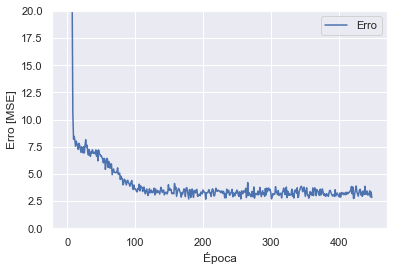

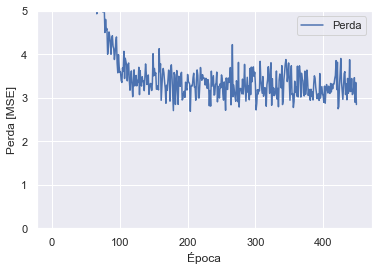

In [152]:
def plot_history():
    hist = pd.DataFrame(grid_result.best_estimator_['estimator'].model.history.history)
    hist.reset_index(inplace=True)
    hist = hist.rename(columns = {'index':'epoch'})

    plt.figure()
    plt.xlabel('Época')
    plt.ylabel('Erro [MSE]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Erro')
    plt.ylim([0,20])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Época')
    plt.ylabel('Perda [MSE]')
    plt.plot(hist['epoch'], hist['loss'],
           label='Perda')
    plt.ylim([0,5])
    plt.legend()
    plt.show()


plot_history()

In [153]:
print((end-start)/60)

21.84087365468343


In [154]:
predictions = grid_result.predict(dum_df_teste)

11/11 [==============================] - 0s 0s/step


In [155]:
for prediction, real in zip(predictions, y_teste):
    print("Prediction: %f - Real: %f - Error: %f" % (prediction, real, real - prediction))

Prediction: 87.819603 - Real: 87.914455 - Error: 0.094852
Prediction: 95.795738 - Real: 94.080925 - Error: -1.714814
Prediction: 86.225105 - Real: 85.977501 - Error: -0.247604
Prediction: 90.799400 - Real: 91.977949 - Error: 1.178549
Prediction: 85.840752 - Real: 85.980207 - Error: 0.139455
Prediction: 92.688187 - Real: 88.231072 - Error: -4.457115
Prediction: 87.849724 - Real: 85.492967 - Error: -2.356757
Prediction: 86.863655 - Real: 88.067656 - Error: 1.204001
Prediction: 88.500542 - Real: 86.053394 - Error: -2.447148
Prediction: 91.736351 - Real: 90.870879 - Error: -0.865472
Prediction: 88.339424 - Real: 85.389330 - Error: -2.950094
Prediction: 93.410019 - Real: 93.445899 - Error: 0.035880
Prediction: 88.548538 - Real: 90.307465 - Error: 1.758927
Prediction: 89.383430 - Real: 88.216717 - Error: -1.166713
Prediction: 87.016586 - Real: 86.695832 - Error: -0.320754
Prediction: 87.585152 - Real: 88.399947 - Error: 0.814796
Prediction: 87.401009 - Real: 86.546034 - Error: -0.854975
Pred

In [156]:
print(mean_absolute_error(predictions, y_teste))

1.2100007663632735


In [157]:
print(mean_squared_error(predictions, y_teste))

2.459140049128765


In [158]:
print(mean_squared_error(predictions, y_teste, squared=False))

1.56816454784846


In [159]:
print(r2_score(predictions, y_teste))

0.7799364710161865


In [160]:
error = y_teste - predictions

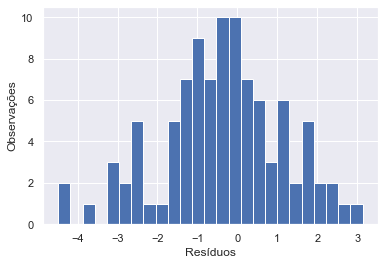

In [162]:
plt.hist(error, bins = 25)
plt.xlabel("Resíduos")
_ = plt.ylabel("Observações")

In [163]:
resultados = pd.DataFrame({'Valores Preditos':predictions, 'Resíduos':error})

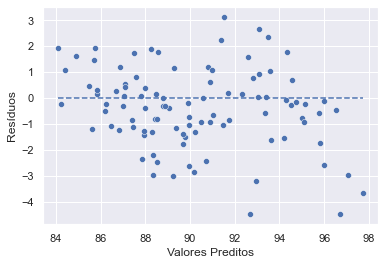

In [164]:
sns.scatterplot(data=resultados, x="Valores Preditos", y="Resíduos")
ax = sns.lineplot(x=resultados['Valores Preditos'],y=0, dashes=[(2, 2), (2, 2)])
ax.lines[0].set_linestyle("--")
plt.show()

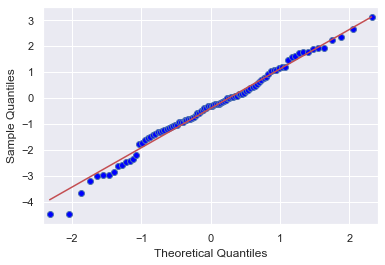

In [165]:
qqplot(error, line='s')
plt.show()

In [166]:
sp = shapiro(error)
sp

ShapiroResult(statistic=0.9875332117080688, pvalue=0.48935666680336)

In [167]:
nt = normaltest(error)
nt

NormaltestResult(statistic=1.6139657785762849, pvalue=0.44620227905958043)

In [168]:
lf = lilliefors(error)
lf

(0.0635643431916332, 0.4419051237360718)

In [169]:
result = anderson(error)
print('Statistic: %.3f' % result.statistic)
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.379
15.000: 0.555, data looks normal (fail to reject H0)
10.000: 0.632, data looks normal (fail to reject H0)
5.000: 0.758, data looks normal (fail to reject H0)
2.500: 0.884, data looks normal (fail to reject H0)
1.000: 1.052, data looks normal (fail to reject H0)


In [170]:
result

AndersonResult(statistic=0.37857987195829423, critical_values=array([0.555, 0.632, 0.758, 0.884, 1.052]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [171]:
model = grid_result.best_estimator_['estimator'].model

In [172]:
#model.get_config()

In [173]:
model.loss

'mse'

In [174]:
model.optimizer

In [175]:
model_json = model.to_json()

In [176]:
with open("cuc_1_10_model.json", "w") as json_file:
    json_file.write(model_json)

In [177]:
model.save_weights("cuc_1_10_weights.h5")

In [ ]:
j_file = open('cuc_experimento_1_layer_model.json', 'r')

In [ ]:
j_model = j_file.read()

In [ ]:
j_file.close()

In [ ]:
loaded_model = model_from_json(j_model)

In [ ]:
loaded_model.load_weights("cuc_experimento_1_layer_weights.h5")

In [ ]:
loaded_model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['mae', 'mse', keras.metrics.RootMeanSquaredError()]
    )